In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [1]:
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import os
from PIL import Image

import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO


In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0))
# print(torch.cuda.memory_usage(0))

The code will run on GPU.
Tesla V100-PCIE-32GB


In [3]:
ROOT_PATH = '/dtu/datasets1/02514/data_wastedetection'
anns_file_path = ROOT_PATH + '/' + 'annotations.json'

In [4]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Read annotations

with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1
super_cat_names = ["background"]+super_cat_names

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500


### Linking the regulear categories to super categories

In [5]:
cat_ids_2_supercat_ids = {}
for cat in categories:
    cat_ids_2_supercat_ids[cat['id']+1] = super_cat_ids[cat['supercategory']]+1
    
class label(object):
    def __init__(self,cat_ids_2_supercat_ids):
        self.cat_ids_2_super_cat_ids = cat_ids_2_supercat_ids
    def __call__(self,sample):
        for i in range(len(sample)):
            sample[i]["category_id"] = cat_ids_2_supercat_ids[sample[i]["category_id"]]
        return sample

In [6]:
train_transform = transforms.Compose([transforms.Resize((500, 500)),
                                     ])

In [7]:
def get_iou(data, ss,x_scale,y_scale):
    gt = []
    inside_gt = []
    background = []
    
    for objects in range(len(data)):
        gt.append(data[objects]["bbox"])
        x11 = gt[objects][0]*x_scale
        y11 = gt[objects][1]*y_scale
        x12 = (gt[objects][2]*x_scale)+x11
        y12 = (gt[objects][3]*y_scale)+y11
        add_background = False
        for index,candidates in enumerate(ss):

            x21 = ss[index][0]
            y21 = ss[index][1]
            x22 = ss[index][2]+x21
            y22 = ss[index][3]+y21
            
            box1 = torch.tensor([[x11, y11, x12, y12]], dtype=torch.float)
            box2 = torch.tensor([[x21, y21, x22, y22]], dtype=torch.float)
            iou = float(bops.box_iou(box1, box2).cpu())
            if iou > 0.5:
                inside_gt.append([[x21,y21,x22-x21,y22-y21],data[objects]["category_id"]])
                add_background = True
                
            if (add_background == True) & (iou < 0.20):
                background.append([[x21,y21,x22-x21,y22-y21],0])
                add_background = False
                
                
    return inside_gt+background

In [8]:
class CocoDetection(torch.utils.data.Dataset):
    """`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    def __init__(self, root, annFile, transform=None, target_transform=None):
        from pycocotools.coco import COCO
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(self.coco.imgs.keys())
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        coco = self.coco
        self.img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=self.img_id)
        target = coco.loadAnns(ann_ids)

        path = coco.loadImgs(self.img_id)[0]['file_name']

        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            
            target = self.target_transform(target)
        
        return img, target


    def __len__(self):
        return len(self.ids)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += 'Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += 'Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str


In [9]:
batch_size = 1
coco = COCO(anns_file_path)

dataset = CocoDetection(ROOT_PATH,anns_file_path,target_transform=label(cat_ids_2_supercat_ids),transform=train_transform)

trainsize = int(0.8*len(dataset))
testsize = len(dataset)-trainsize

train_data,test_data = torch.utils.data.random_split(dataset,[trainsize,testsize])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=3,collate_fn=lambda x: x)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=3,collate_fn=lambda x: x)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [9]:
import cv2
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import numpy as np
from matplotlib.patches import Rectangle
import torchvision.ops.boxes as bops

In [18]:
image,data = next(iter(train_loader))

In [18]:
og_height = coco.loadImgs(data[0]["image_id"])[0]["height"]
og_width  = coco.loadImgs(data[0]["image_id"])[0]["width"]
x_scale = 500/og_width
y_scale = 500/og_height

KeyboardInterrupt: 

In [48]:
image = np.asarray(image)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

NameError: name 'image' is not defined

In [16]:
inside = get_iou(data,rects)
print(len(inside))

94


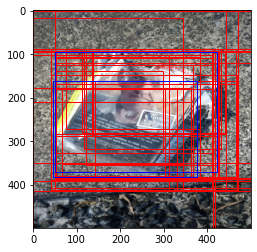

In [17]:
plt.imshow(image)

for index,rect in enumerate(inside):
    plt.gca().add_patch(Rectangle((rect[0],rect[1]),rect[2],rect[3],
                        edgecolor='red',
                        facecolor='none',
                        lw=1))
    for i in range(len(data)):
        plt.gca().add_patch(Rectangle((data[i]["bbox"][0]*x_scale,data[i]["bbox"][1]*y_scale),data[i]["bbox"][2]*x_scale,data[i]["bbox"][3]*y_scale,
                            edgecolor='blue',
                            facecolor='none',
                            lw=1))


### Creating model and training loop

In [10]:
batch_size = 2
coco = COCO(anns_file_path)

dataset = CocoDetection(ROOT_PATH,anns_file_path,target_transform=label(cat_ids_2_supercat_ids),transform=train_transform)

trainsize = int(0.8*len(dataset))
testsize = len(dataset)-trainsize

train_data,test_data = torch.utils.data.random_split(dataset,[trainsize,testsize])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=3,collate_fn=lambda x: x)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=3,collate_fn=lambda x: x)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!


In [11]:
from torchvision import models
import torch.optim as optim

In [12]:
model = models.mobilenet_v3_large()

### Changing the last layer to be 10 instead of 1000
model.classifier[3] = nn.Linear(1280,60,bias=True)

model = model.to(device)

In [13]:
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [81]:
crop_images = train(model,optimizer)

  0%|          | 0/1 [00:00<?, ?epoch/s]

(500, 500, 3)
(500, 500, 3)


In [87]:
variable = DataLoader(crop_images, shuffle=True, num_workers=3)

In [88]:
vari

In [80]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=1):
    #def loss_fun(output, target):
    #    return F.nll_loss(torch.log(output), target)
    loss_fun = nn.CrossEntropyLoss()
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        crop_images = []
        #a = np.asarray(next(iter(train_loader)))
        
        for minibatch_number, images in enumerate(train_loader):
            for index, (image,data) in enumerate(images):
                
                ### Running selective search on image
                np_image = np.asarray(image)
                ss.setBaseImage(np_image)
                ss.switchToSelectiveSearchFast()
                print(np_image.shape)
                rects = ss.process()
                
                
                og_height = coco.loadImgs(data[0]["image_id"])[0]["height"]
                og_width  = coco.loadImgs(data[0]["image_id"])[0]["width"]
                x_scale = 500/og_width
                y_scale = 500/og_height
                
                crop_rects_and_labels = get_iou(data,rects,x_scale,y_scale)
                
                for rects_and_labels in crop_rects_and_labels:
                    (x1,y1,w,h),(label) = rects_and_labels
                    x2 = x1+w
                    y2 = y1+h
                    crop_images.append(tuple([transforms.functional.pil_to_tensor(transforms.functional.resize(image.crop((x1,y1,x2,y2)),(60,60))).to(dtype=torch.float32),label]))                                     
                                                            
            return crop_images
            break
